In [1]:
# Common imports 
from ast import literal_eval

import gensim
import numpy as np
import pandas as pd

from categorical_em import CategoricalEM
import sys
print(sys.version)

3.7.5 (default, Oct 25 2019, 15:51:11) 
[GCC 7.3.0]


## 1. Hyperparameters


In [2]:
K = 5 # Number of mixture components
I = 120 # Number of words in the dictionary
N = None # Number of documents

## 2. Load and preprocess the data

First, we need to load the data from the csv. This file contains the documents already processed and cleaned after applying the following steps:

1. Tokenization
2. Homogeneization, which includes:
    1. Removing capitalization.
    2. Removing non alphanumeric tokens (e.g. punktuation signs)
    3. Stemming/Lemmatization.
3. Cleaning
4. Vectorization


We load it as a `pandas` dataframe.


In [3]:
df = pd.read_csv('tweets_cleaned.csv')
df.drop_duplicates(subset="tweet", inplace=True)

df['tokens'] = df['tokens'].apply(literal_eval) #Transform the string into a list of tokens
X_tokens = list(df['tokens'].values)


In [4]:
print('Columns: {}\n'.format(' | '.join(df.columns.values)))

print('Tweet:\n{}'.format(df.loc[1, 'tweet']))
print('Tweet cleaned:\n{}'.format(df.loc[1, 'tweets_clean']))
print('Tweet tokens:\n{}'.format(X_tokens[1]))

Columns: tweet_id | timestamp | user_id | tweet | tweets_clean | tokens

Tweet:
OSINT people - please retweet, if possible. My friend is looking for women involved in OSINT. https://twitter.com/manisha_bot/status/1181594280336531457 …
Tweet cleaned:
osint people   please retweet  if possible  my friend is looking for women involved in osint
Tweet tokens:
['osint', 'peopl', 'retweet', 'possibl', 'friend', 'look', 'woman', 'involv', 'osint']


### Create the dictionary

Up to this point, we have transformed the raw text collection in a list of documents stored in `X_tokens`, where each document is a collection 
of the words that are most relevant for semantic analysis. Now, we need to convert these data (a list of token lists) into 
a numerical representation (a list of vectors, or a matrix). To do so, we will start using the tools provided by the `gensim` library. 

As a first step, we create a dictionary containing all tokens in our text corpus, and assigning an integer identifier to each one of them.



In [5]:
dictionary = gensim.corpora.Dictionary(X_tokens)

dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=I)


### Create Bag of Words (BoW): Numerical version of documents
In the second step, let us create a numerical version of our corpus using the `doc2bow` method. In general, 
`D.doc2bow(token_list)` transforms any list of tokens into a list of tuples `(token_id, n)`, one per each token in 
`token_list`, where `token_id` is the token identifier (according to dictionary `D`) and `n` is the number of occurrences 
of such token in `token_list`. 

*Exercise:* Apply the `doc2bow` method from gensim dictionary `D`, to all tokens in every document in `X_tokens`. 
The result must be a new list named `X_bow` where each element is a list of tuples `(token_id, number_of_occurrences)`.

In [6]:
X_bow = list()
keep_tweet = list()
for tweet in X_tokens:
    tweet_bow = dictionary.doc2bow(tweet)
    if len(tweet_bow) > 1:
        X_bow.append(tweet_bow)
        keep_tweet.append(True)
    else:
        keep_tweet.append(False)

df_data = df[keep_tweet]

N = len(df_data)


Finally, we transform the BoW representation `X_bow` into a matrix, namely `X_matrix`, in which the i-th row and j-th column represents the 
number of occurrences of the j-th word of the dictionary in the i-th document. This will be the matrix used in the algorithm.

In [7]:
X_matrix = np.zeros([N, I])
for i, doc_bow in enumerate(X_bow):
    word_list = list()
    for word in doc_bow:
        X_matrix[i, word[0]] = word[1]


## 3. Categorical Mixture Model with Expectation Maximization

### Exercise 1: Analytical forms of the E and M steps for the EM-Algorithm
1. Write the joint distribution: $p(\{\mathbf{x}_n, z_n\}| \Theta) = ?$
2. Write the analytical expression for $Q(\Theta, \Theta^{\text{old}}) = ?$
3. Write the MLE for $\Theta$


#### Exercise 1.1

\begin{align}
p(\{\mathbf{x}_n, z_n\}| \Theta) &=  \cdots \\
\ln(p(\{\mathbf{x}_n, z_n\}| \Theta) &= \cdots = ... = \sum_{i=1}^N \left(\ln(\pi_{z_n}) + \sum_{j=1}^{W_n} \ln(\theta_{z_n x_{n_j}}) \right)
\end{align}

#### Exercise 1.2

\begin{align}
Q(\Theta, \Theta^{\text{old}}) = \cdots = \sum_{n=1}^N\sum_{k=1}^K p(z_n = k \vert x_n,\Theta^{old})\left(\ln(\pi_k) + \sum_{j=1}^{W_n} \ln(\theta_{kx_{n_j}})\right)\\
p(z_n = k \vert x_n,\Theta^{old}) = \cdots = \frac{\pi_k \prod_{i=1}^{W_n} \theta_{kx_{n_i}}^{old}}{\sum_{l=1}^K \pi_l \prod_{j=1}^{W_n}\theta_{kx_{n_j}}^{old}} \\
\end{align}

#### Exercise 1.3
\begin{align}
\hat{\pi}_k = \cdots = \frac{N_k}{N} = \frac{\sum_{n=1}^N p(z_n = k \vert x_n, \Theta^{old})}{N}
\end{align}

\begin{align}
\hat{\theta}_{km} = \cdots = \frac{\tilde{N}_{km}}{\tilde{N}_k} = \frac{\sum_{n=1}^N p(z_n = k \vert x_n, \Theta^{old}) c_{nm}}{\sum_{n=1}^N p(z_n = k \vert x_n, \Theta^{old}) W_n} = \frac{\sum_{n=1}^N p(z_n = k \vert x_n, \Theta^{old}) \sum_{j=1}^{W_n}[x_{n_j} = m]}{\sum_{n=1}^N p(z_n = k \vert x_n, \Theta^{old}) W_n}
\end{align}

### Exercise 2: Data anlysis task
#### Exercise 2.1

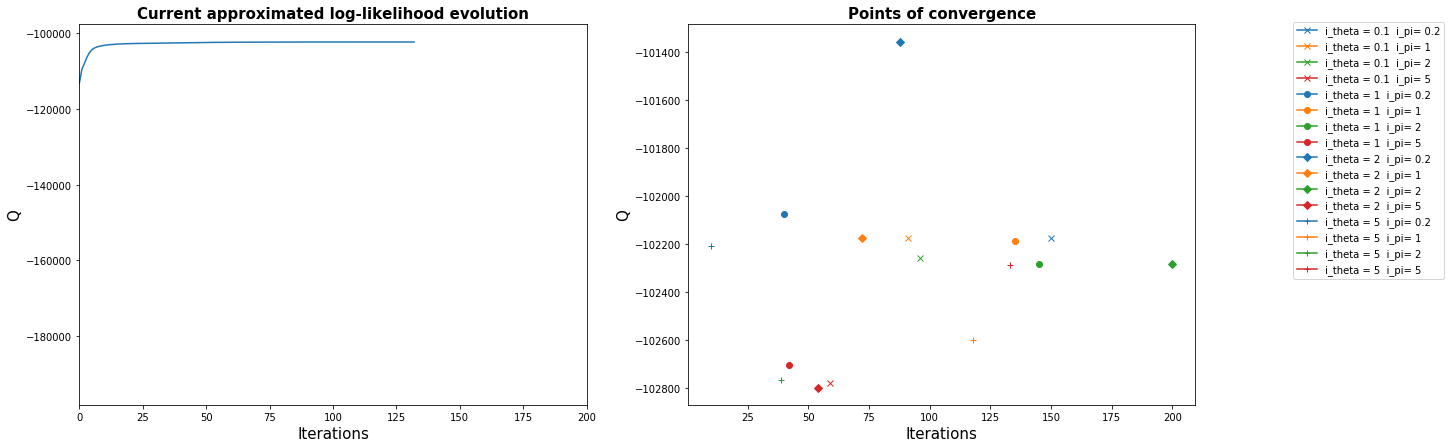

In [8]:
"""
Fix K = 5 and try different initializations.
"""
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

%matplotlib inline

K = 5 # Number of mixture components

i_pis = [1/K, 1, 2, 5]
i_thetas = [1/10, 1, 2, 5]

epochs = 200

# prepare plots
fig_1, ax_1 = plt.subplots(1, 2, figsize=(20, 7))

ax_1[0].set_title("Current approximated log-likelihood evolution", fontsize=15, fontweight='bold')
ax_1[1].set_title("Points of convergence", fontsize=15, fontweight='bold')

ax_1[0].set_ylabel("Q", fontsize=15)
ax_1[0].set_xlabel("Iterations", fontsize=15)

ax_1[1].set_ylabel("Q", fontsize=15)
ax_1[1].set_xlabel("Iterations", fontsize=15)

ax_1[0].set_xlim(0, epochs)

x = np.arange(epochs)
markers = ['x', 'o', 'D', '+']


for i, i_theta in enumerate(i_thetas):
    
    for j, i_pi in enumerate(i_pis):
        
        model = CategoricalEM(K, I, N, delta=0.01, epochs=epochs, init_params={'theta': i_theta, 'pi': i_pi})
        model.fit(X_matrix)
        
        if i == 0 and j == 0:
            line_1,  = ax_1[0].plot(x[:len(model.Q_list)], model.Q_list, label=f"i_theta = {i_theta}  i_pi= {i_pi}")
        else:
            line_1.set_data(x[:len(model.Q_list)], model.Q_list)
            
        ax_1[1].plot(len(model.Q_list), model.Q_list[-1], marker=markers[i], c=f"C{j}",label=f"i_theta = {i_theta}  i_pi= {i_pi}")
        ax_1[1].legend(loc='upper right', bbox_to_anchor=(1, 0.52, 0.5, 0.5))
       
        clear_output(wait=True)
        display(fig_1)

clear_output(wait=True)


#### Exercise 2.2

In [9]:
from utility import log_sum_exp

def log_likelihood(X, pi, theta):
    """
    Computes the log-likelihood logP(x_n | Theta)
    for all n.
    
    Arguments:
        X: np.ndarray, (N x I)
        pi: np.ndarray, (K)
        theta: np.ndarray, (K x I)
    
    Returns:
        log_lik: np.ndarray, (N) represents logP(X | Theta)
    """
    N, _ = X.shape
    K, _ = theta.shape
    
    p_x_tk = np.ones((N, K))
    
    for k in range(K):
        for n in range(N):
            p_x_tk[n, k] = (theta[k] * X[n]).sum(axis=0)
    
    summands = np.repeat(pi[np.newaxis, :], N, axis=0) * p_x_tk
    
    log_lik = log_sum_exp(summands, axis=1)
    
    return log_lik

In [10]:
def AIC(K, I, log_lik):
    """
    Computes the Akaike Information Criterion.
    
    Arguments
        K: integer, number of mixture components (clusters)
        I: integer, number of words in the dictionary
        log_lik: float, log-likelihood
    
    Returns 
        float, Akaike Information Criterion
    """
    return 2*(K * I - log_lik)

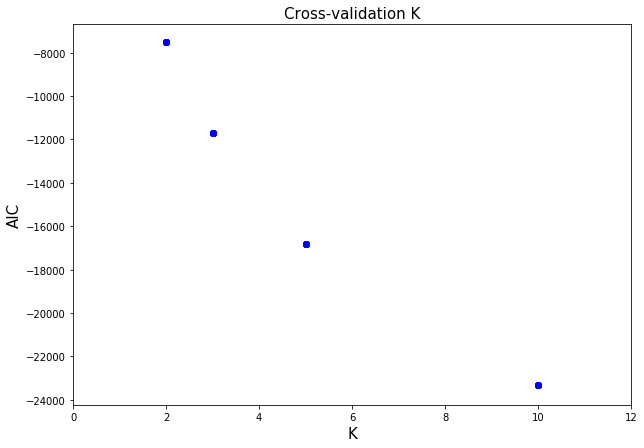

In [11]:
"""
Cross validate the number of components K = {2, 3, 5, 10} according to the Akaike Information
Criterion (AIC). You will need to implement the formula for the AIC.
"""
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline

n_runs = 5
Ks = [2, 3, 5, 10] # Number of mixture components

epochs = 200

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.set_title("Cross-validation K", fontsize=15)
ax.set_ylabel("AIC", fontsize=15)
ax.set_xlabel("K",fontsize=15)
ax.set_xlim(0, 12)

x= np.arange(epochs)

for k_idx, k in enumerate(Ks):
        
    for n in range(n_runs):
        # fit the model
        model = CategoricalEM(k, I, N, delta=0.01, epochs=epochs, init_params={'theta': 5, 'pi': 1/k})
        model.fit(X_matrix)
    
        # compute log_likelihood
        log_lik = log_likelihood(X_matrix, model.pi_vector, model.theta_matrix)
        log_lik = log_lik.sum()
        
        # compute Akaike Information Criterion
        aic = AIC(k, I, log_lik)

        # plot AIC
        ax.scatter(k, aic, c='blue')
        
        clear_output(wait=True)
        display(fig)

clear_output(wait=True)

#### Exercise 2.3

Some useful packages:
- matplotlib https://matplotlib.org/
- seaborn https://github.com/mwaskom/seaborn
- wordcloud https://github.com/amueller/word_cloud
- probvis https://github.com/psanch21/prob-visualize



In [12]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
%matplotlib inline

ITER: 0 Q= -117420.114 diff= 200
ITER: 5 Q= -104948.1382 diff= 236.6226
ITER: 10 Q= -104306.394 diff= 105.4545
ITER: 15 Q= -103865.8727 diff= 76.4007
ITER: 20 Q= -103597.9761 diff= 50.2883
ITER: 25 Q= -103261.9771 diff= 83.9426
ITER: 30 Q= -102749.7924 diff= 104.759
ITER: 35 Q= -102524.1715 diff= 21.1414
ITER: 40 Q= -102423.4186 diff= 20.5505
ITER: 45 Q= -102367.7673 diff= 13.7217
ITER: 50 Q= -102312.3556 diff= 14.9888
ITER: 55 Q= -102281.7807 diff= 3.3316
ITER: 60 Q= -102260.9078 diff= 1.0821
ITER: 65 Q= -102250.189 diff= 1.3699
ITER: 70 Q= -102242.4498 diff= 5.4964
ITER: 73 Q= -102233.4692 diff= -0.4642


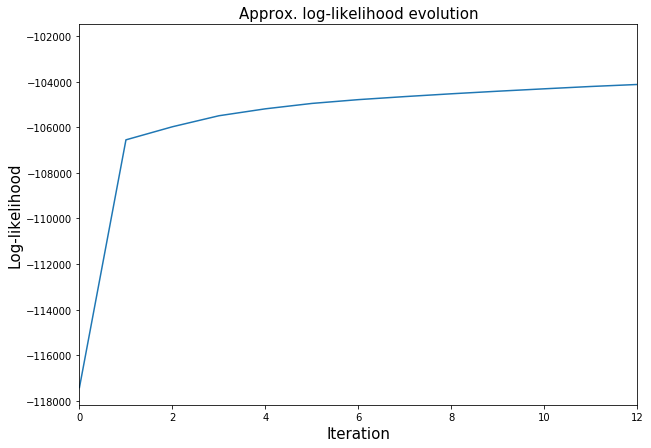

In [13]:
"""
For the optimal value ofKaccording to AIC, show i) the (approximated) log-likelihood evolution per iteration
"""
K = 10

epochs = 200

fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.set_title("Approx. log-likelihood evolution", fontsize=15)
ax.set_ylabel("Log-likelihood", fontsize=15)
ax.set_xlabel("Iteration",fontsize=15)
ax.set_xlim(0, 12)

x= np.arange(epochs)

# fit the model
model = CategoricalEM(K, I, N, delta=0.01, epochs=epochs, init_params={'theta': 1, 'pi': 1/k})
model.fit(X_matrix)
    
# plot evolution of log-likelihood
ax.plot(x[:len(model.Q_list)], model.Q_list)

In [14]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

tweet_array = np.array(df_data['tweet'].values)

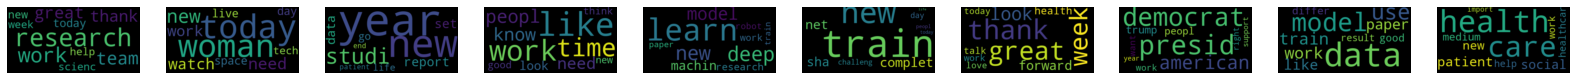

In [15]:
"""
Show the 10 most representative words for each topic using a cloud of words
"""

fig, ax = plt.subplots(1, K, figsize=(28,15))

for k in range(K):
    theta_k = model.theta_matrix[k]
    
    # get indices of 10 most representative words
    ind = np.argsort(theta_k)[-10:]
    
    words = [dictionary[i] for i in ind]     
    frequencies = {word:freq for word, freq in zip(words, theta_k[ind])}
    
    # generate wordcloud
    wordcloud = WordCloud().generate_from_frequencies(frequencies)
    
    ax[k].imshow(wordcloud, interpolation='bilinear')
    ax[k].axis("off")

In [16]:
"""
Show the 10 most relevant documents for each topic.
"""

p_x_tk = np.ones((N, K))
    
for k in range(K):
    for n in range(N):
        p_x_tk[n, k] = (model.theta_matrix[k] * X_matrix[n]).sum(axis=0)
    
for k in range(K):
    
    # get indices of 10 most relevant documents
    ind = np.argsort(p_x_tk[:, k])[-10:]
    
    for i, idx in enumerate(ind):
        print(f"\nCluster {k} \t tweet {i+1}:")
        print(tweet_array[idx])


Cluster 0 	 tweet 1:
It's really exciting to see this research coming out from the DeepMind Health Research team. Expert-level performance, with potential real-world impact - excited to see this project develop - Ashley. https://deepmind.com/blog/moorfields-major-milestone/ …

Cluster 0 	 tweet 2:
Navigating the complex tactics of team play is a critical challenge of AI research. In our new paper–now published in @sciencemagazine–we present new developments in reinforcement learning, resulting in human-level performance in Quake III–Capture the Flag  https://science.sciencemag.org/cgi/doi/10.1126/science.aau6249 … pic.twitter.com/8BOAFzX1Ex

Cluster 0 	 tweet 3:
Part of my role is to support the DeepMind Health team to engage patients in our research, direct care and engagement work. It's something I feel very passionate about and looking forward to sharing more over the coming weeks. - Dom

Cluster 0 	 tweet 4:
2) providing compute resource opportunities for African researchers &stud